In [13]:
import numpy as np

    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import pickle as pkl

from jax import jit
from jax import numpy as jp

import cvxpy as cp

from RKHS import Gram
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def h(r,c,l):
    return c * jp.exp(-(r**2) / l**2)

# The differentiable kernel function with parameters c,l not filled.

def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return h(jp.linalg.norm(x1-x2+small_sig,axis = -1),c,l)

In [3]:
def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,jp.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*jp.log(jp.linalg.det(np.eye(len(KA))+KA/var_0))
    else:
        return 1/2*jp.log(jp.linalg.det(KA))

# Experiment parameters

In [22]:
T = 19

c = 1
l = 1
var_0 = 0.01


search_region_center = np.array([0.,0.])
search_region_radius = 1
step_size = 1

# The reference system.
ref = np.array([[0,0]]) # A single point reference set.
R = np.array([search_region_radius*np.ones(T)]).T
R[0,0] = 0

N = len(ref)

x0 = search_region_center

# Callables

In [7]:

x_objective = jit(lambda z: GPMI(z,c=c,l=l,var_0=var_0))

kernel = partial(k,c=c,l=l)


# Solve for the upper bound under the bounded region constraint
Given reference points $a_{1:N}$, inducing $A = [k(a_i,a_j)]$.

The ultimate problem we attempt to solve is,

$$
		\max_{x_1,x_2,...,x_{T}} F(x_{1:T})\\
        ~||x_{t+1}-x_t||\leq D,~\forall t=1,...,T-1\\
		~ ||x_t-a_k||\leq R_{t,k},~\forall 1\leq t \leq T,~1\leq k\leq N
$$

where $R_{t,k}$ are pre-specified distance bounds to the reference points. 

The convex relaxation of the above we consider hereafter is
$$
    \max_{\Sigma,B}~\log\det(I+\Sigma/\sigma^2)\\
		s.t.~M=\begin{bmatrix}
    \Sigma & B\\
B^\top & A
\end{bmatrix}\succ 0\\
~\Sigma_{ii}=c,\forall i=1,2,...,T\\
~\Sigma_{i,i+1}\geq d,\forall i=1,...,T-1\\
~B_{ik}\geq b_{ik}=h(R_{i,k}),\forall i,k\\
(\text{Without admissibility constraints})
$$

Very often we want to impose the constraint that the initial location $x_1$ is fixed, this can be achieve by specifying the desired initial location as the value of $a_1$ and impose $||x_1-a_1||\leq 0$, or $b_{11} = h(0)$.

The optimal value of the convex relaxation is an upper bound on the ultimate problem, which could be loose.


In [23]:

d = h(step_size,c=c,l=l)

A = Gram(kernel,ref)

N = len(A)



b = np.ones((T,N))*np.array(h(R,c=c,l=l))
b[0,0] = h(0,c=c,l=l) # Initial location constraint.

In [24]:
# Define and solve the problem
B = cp.Variable((T,N))

S = cp.Variable((T,T),symmetric=True)

M = cp.vstack([cp.hstack([S,B]),
               cp.hstack([B.T,A])])


constraints = [M>>0]


constraints += [cp.diag(S)==c]

constraints += [S[i,i+1]>=d for i in range(0,T-2)]

constraints += [S>=h(2*search_region_radius,c,l)]

constraints += [B>=1*b]



prob = cp.Problem(cp.Maximize(1/2*cp.log_det(np.eye(T)+ S/var_0)),constraints)

upper_bound = prob.solve()

In [25]:
upper_bound

41.99077922957981

In [27]:
S_target = S.value

# Can we use the incremental greedy idea to build a set of $x_{1:T}$ the imitates the optimal $\Sigma$ value as above?

In [140]:
xs = [x0]

ref=search_region_center
R = search_region_radius
n_test = 2 * 10 ** 5

for _ in range(T-1):
    t = len(xs)
    
    print(t)
    # Generate the feasible random samples
    rand_theta = np.random.rand(n_test)*2*np.pi

    rand_dir = np.array([np.cos(rand_theta),np.sin(rand_theta)])

    x_test = xs[-1]+(step_size*np.random.rand(n_test)*rand_dir).T # Step size constraint.

    x_test = x_test[(np.linalg.norm(x_test[:,np.newaxis,:]-ref,axis=-1)<=R).ravel()] # Bounded region constraint.



    k_t = kernel(x_test[:,np.newaxis,:],xs)

    k_target = S_target[t,:t]
    
    

    x_new = x_test[np.argmin(np.linalg.norm(k_t-k_target,axis=1))]
    
#     print(k_target,kernel(x_new,xs),np.linalg.norm(k_t-k_target,axis=1))
    
    xs.append(x_new)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [122]:
k_t.shape

(2, 83823)

In [123]:
k_target.shape

(2,)

In [144]:
np.linalg.norm(Gram(kernel,np.array(xs))-S_target)

5.386325

In [145]:
np.array(xs)

array([[ 0.00000000e+00,  0.00000000e+00],
       [-5.81104916e-03,  9.99959970e-01],
       [ 8.59885496e-01,  5.09605638e-01],
       [ 8.62977222e-01, -4.62056784e-01],
       [ 3.18270175e-02, -9.62229914e-01],
       [-8.13171751e-01, -4.48025574e-01],
       [-9.25758589e-01,  3.72377912e-01],
       [-7.06200656e-01,  7.07021759e-01],
       [ 1.13670273e-02,  1.43273126e-01],
       [ 4.98622826e-01,  8.65326396e-01],
       [ 9.97553254e-01,  2.16529236e-05],
       [ 5.23141042e-01, -8.51571143e-01],
       [-4.66191782e-01, -8.84627592e-01],
       [-9.25609848e-01, -3.76500873e-01],
       [-9.97203523e-01,  7.07442668e-02],
       [-4.51129406e-01,  8.91798850e-01],
       [ 1.89734935e-01,  9.81146239e-01],
       [ 9.41826091e-01,  3.34742614e-01],
       [ 7.70505584e-01, -6.37357850e-01]])

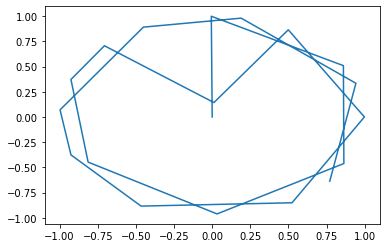

In [146]:
xs = np.array(xs)
plt.plot(xs[:,0],xs[:,1])

In [147]:
x_objective(xs)

DeviceArray(24.473446, dtype=float32)

In [149]:
from Algorithms import incremental_greedy
greedy = incremental_greedy(kernel,x0,step_size,ref,search_region_radius,T,var_0,c)

In [150]:
x_objective(greedy)

DeviceArray(27.517815, dtype=float32)

In [151]:
Gram(kernel,greedy)

DeviceArray([[1.        , 0.36788914, 0.36860484, 0.37370336, 0.36871442,
              0.36802685, 0.36820853, 0.3679183 , 0.730579  , 0.3680269 ,
              0.75894946, 0.3715569 , 0.7064949 , 0.36811358, 0.7322672 ,
              0.3684284 , 0.68448293, 0.36811787, 0.70093924],
             [0.36788914, 1.        , 0.37040672, 0.05112127, 0.01840004,
              0.04956082, 0.36305362, 0.7579133 , 0.7274078 , 0.13446093,
              0.14247999, 0.02248473, 0.26425064, 0.1344296 , 0.09602817,
              0.02419863, 0.32902825, 0.75135124, 0.7106583 ],
             [0.36860484, 0.37040672, 1.        , 0.37002492, 0.05008275,
              0.01840269, 0.04961499, 0.13405427, 0.6923058 , 0.75994974,
              0.400373  , 0.02681878, 0.09489482, 0.02405305, 0.1111746 ,
              0.13698381, 0.8147834 , 0.7812391 , 0.25013196],
             [0.37370336, 0.05112127, 0.37002492, 1.        , 0.37214553,
              0.05112601, 0.01893574, 0.02447931, 0.25962794, 0.7704245

## Can we use the incremental greedy idea to build a set of $x_{1:T}$ the imitates the optimal $\Sigma$ value as above?

We can, but the resulting objective is not as good as incremental greedy.

In [152]:
S_target

array([[1.00001807, 0.36787963, 0.36422426, 0.36347305, 0.36327144,
        0.36321732, 0.3632028 , 0.3631989 , 0.36319785, 0.36319757,
        0.36319749, 0.36319747, 0.36319747, 0.36319746, 0.36319746,
        0.36319745, 0.36319741, 0.36320855, 0.36321918],
       [0.36787963, 1.00000044, 0.36787963, 0.1958068 , 0.14962952,
        0.13723563, 0.1339086 , 0.13301533, 0.13277546, 0.13271104,
        0.13269373, 0.13268907, 0.13268782, 0.13268746, 0.13268727,
        0.13268688, 0.13268552, 0.1326846 , 0.13268166],
       [0.36422426, 0.36787963, 1.00000044, 0.36787963, 0.19558403,
        0.14934681, 0.13693672, 0.1336053 , 0.13271084, 0.13247065,
        0.13240613, 0.1323888 , 0.13238414, 0.13238285, 0.1323824 ,
        0.13238188, 0.13238025, 0.13237838, 0.13237415],
       [0.36347305, 0.1958068 , 0.36787963, 1.00000044, 0.36787963,
        0.19558519, 0.14934833, 0.13693832, 0.13360693, 0.13271248,
        0.13247228, 0.13240777, 0.13239043, 0.13238574, 0.13238436,
        0.132

In [153]:
Gram(kernel,xs)

DeviceArray([[1.        , 0.3678965 , 0.36821032, 0.3835727 , 0.39577895,
              0.42232707, 0.36946684, 0.36839515, 0.9795555 , 0.3688318 ,
              0.3696819 , 0.36830276, 0.367916  , 0.3684293 , 0.368093  ,
              0.36831272, 0.3683774 , 0.36821476, 0.36791486],
             [0.3678965 , 1.        , 0.37162206, 0.05544932, 0.02124559,
              0.06402423, 0.28933716, 0.56194097, 0.4798856 , 0.76141274,
              0.13444275, 0.02452756, 0.02319959, 0.06452684, 0.15781987,
              0.81057835, 0.962143  , 0.26170686, 0.03749764],
             [0.36821032, 0.37162206, 1.        , 0.38901502, 0.05772988,
              0.02432678, 0.04046346, 0.08277749, 0.42563075, 0.77333105,
              0.7568212 , 0.13998795, 0.02466508, 0.01881354, 0.02621616,
              0.15492226, 0.51096594, 0.9633954 , 0.26619822],
             [0.3835727 , 0.05544932, 0.38901502, 1.        , 0.39024368,
              0.06022471, 0.02032594, 0.02172995, 0.33565742, 0.1503634